looking thru: https://www.midi.org/forum/279-yamaha-bull-dump-data-format,
http://rnhart.net/articles/bulk-dump.htm

In [280]:
with open('syxout.txt') as hexdata:
    lines = [bytearray.fromhex(line.strip()) for line in hexdata]

In [281]:
def tohex(by):
    return " ".join("%02X"%x for x in by)
def tobin(by):
    return " ".join("{:08b}".format(x) for x in by)

In [282]:
for line in lines:
    print(tohex(line[:20]), "...", tohex(line[-4:]))

('F0 43 73 7F 44 06 0A 10 00 10 00 00 00 00 1F 00 0A 03 68 03', '...', '37 00 3B F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 10 00 00 37 00 03 45 7F', '...', '3B 10 0A F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 20 00 55 27 37 42 00 33', '...', '41 00 28 F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 30 00 20 00 32 00 00 00', '...', '4B 00 56 F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 40 00 00 05 48 4F 01 24', '...', '41 00 67 F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 50 00 20 00 33 00 00 00', '...', '0B 00 6C F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 60 00 3B 21 01 43 00 01', '...', '24 00 4D F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 00 70 00 29 2F 2F 51 44 01', '...', '00 00 1C F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 01 00 00 00 46 43 02 4A 42', '...', '40 22 21 F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 01 10 00 00 02 12 1D 42 29', '...', '43 00 54 F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 01 20 00 45 02 3E 00 00 37', '...', '4F 00 6D F7')
('F0 43 73 7F 44 06 0A 10 00 10 00 01 30 00 00 06 48 5

In [283]:
lb = lines[0]
ls = lines[-4]

manufacturer/device/data type header: F0 43 73 7F 44 06. TT=0A indicates song data apparently.

In [284]:
tohex(lb[:7])

'F0 43 73 7F 44 06 0A'

'SS' Size bytes. 

There appear to be four of them. At the EOS this is '00 01 00 01'
the longest messages have this as '10 00 10 00', the last message before EOS has this as '08 68 08 68'.


It appears to be two repeated
 (at least, in the case of the 0A. The 09 data, with only one message, appears to be different again.)

In [285]:
tohex(lb[7:11])

'10 00 10 00'

three 'ZZ' running total bytes. 

At the EOS this is '7F 7F 7F', then immediately followed by the end F7.


In [286]:
tohex(lb[11:14])

'00 00 00'

the 'KK' checksum and end-of-message flag F7.

In [287]:
tohex(lb[-2:])


'3B F7'

This should, and I say *should*, be of a similar format, so...
If this works, sum of SS SS SS to KK inclusive should be 0 (mod 128).

In [288]:
[sum(line[7:-1]) % 128 for line in lines]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 127,
 0,
 127]

In [289]:
def unpackseven(by):
    # Ignore the first bit, which is always zero.
    # The most signifcant bit comes first
    sum = 0
    for v, b in zip(by, range(len(by)-1, -1, -1)):
        sum += v << (b*7)
    return sum

In [290]:
"%X"%(unpackseven(bytearray.fromhex('10 00')))
# 0x800, or 2048 bytes of encoded data seems to be the maximum.
# the ZZ bytes appear to increment by this amount 

'800'

In [291]:
pay1=lb[14:-2]

In [292]:
len(pay1)

2048

In [293]:
"%X"%(unpackseven(bytearray.fromhex('08 68')))
# that penultimate message should be 0x468, or 1128, bytes

'468'

In [294]:
unpackseven(ls[9:11]) == len(ls[14:-2])

True

In [295]:
len(ls[14:-2])

1128

Instead encoding one byte to two by nybble, with 0F 07 == 7F like in the [PSR-225](http://rnhart.net/articles/bulk-dump.htm), it seems that the 'payload' data uses all seven available bits, which could mean several things.

In [296]:
payloads = [line[14:-2] for line in lines[:-3]]

In [297]:
payload = bytearray().join(payloads)

From staring at the 'payload' in a hex editor, I have recognised some patterns. I think that every 8th byte is some sort of 'parity' byte or something. Ignoring these bytes you can see the ascii for 'YAMAHA' and 'MTrk' and 'PresetStyle\x00'. So that's a start.

In [298]:
len(payload)/8

9613

In [299]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [300]:
pays = np.array(payload).reshape((9613,8))

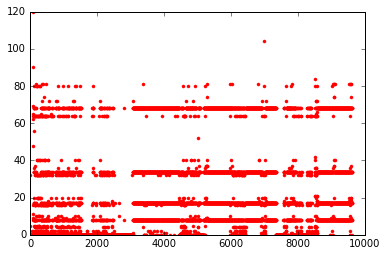

In [301]:
plt.plot(pays[:,7], 'r.')

In [302]:
np.asarray(np.unique(pays[:,7], return_counts=True)).T

array([[   0, 3084],
       [   1,  120],
       [   2,  122],
       [   4,   96],
       [   5,   28],
       [   8, 1468],
       [   9,   18],
       [  10,   25],
       [  11,    1],
       [  16,   93],
       [  17, 1348],
       [  18,   19],
       [  20,   40],
       [  21,    4],
       [  32,  126],
       [  33,    1],
       [  34, 1354],
       [  36,   17],
       [  37,   12],
       [  40,   34],
       [  42,    1],
       [  48,    1],
       [  52,    1],
       [  56,    1],
       [  62,    1],
       [  64,  126],
       [  65,    4],
       [  66,    1],
       [  68, 1398],
       [  69,    1],
       [  72,   16],
       [  74,    5],
       [  80,   25],
       [  81,   18],
       [  84,    1],
       [  90,    1],
       [ 104,    1],
       [ 120,    1]])

In [303]:
tobin(pays[pays[:,7]==65,:][2])

'01110000 00000101 01111110 01111111 00001001 00000001 01110111 01000001'

In [304]:
tobin(np.unique(pays[:,7]))

'00000000 00000001 00000010 00000100 00000101 00001000 00001001 00001010 00001011 00010000 00010001 00010010 00010100 00010101 00100000 00100001 00100010 00100100 00100101 00101000 00101010 00110000 00110100 00111000 00111110 01000000 01000001 01000010 01000100 01000101 01001000 01001010 01010000 01010001 01010100 01011010 01101000 01111000'

... I dunno. Maybe we should just ignore all the 8th bytes.

In [305]:
payload7 = bytearray()
for i in range(0, len(payload), 8):
    payload7.extend(payload[i:i+7])

If I had to squeeze 8 bits down into seven, how would I do it?
Maybe, we take each of the seven bits of the eighth byte and stick them in front of the previous seven?

In [306]:
def reconstitute(by):
    blob = by[:7]
    for i in range(7):
        bitmask = 0b01000000 >> i
        blob[i] = blob[i] | ((by[7] & bitmask) << i+1)
    return blob

In [307]:
pgroups = [payload[i:i+8] for i in range(0, len(payload), 8)]

In [308]:
payload8 = bytearray().join(reconstitute(g) for g in pgroups)